todo: create a folder original_data/ with the same path of this file
, download dataset https://www.kaggle.com/datasets/andradaolteanu/gtzan-dataset-music-genre-classification, this jupyter is doing 4-genre classification because of limited RAM


# Data proprocessing

## loading the data with feature extraction

In [ ]:
!pip install speechbrain

In [ ]:
import os
import re
import speechbrain as sb
from speechbrain.processing.features import STFT, spectral_magnitude, Filterbank
import torch
import torch.nn as nn
import torchaudio
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
os.chdir('/content/drive/MyDrive/music_genre_classification-master')
os.listdir()

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


['README.md',
 'main.py',
 '.gitignore',
 'trainers',
 'saved_models',
 'jupyter',
 'models',
 'original_data',
 'data_loader',
 'data_processor',
 'loggers',
 'jupyter_of_CRDNN.ipynb',
 'saved_CRNN_wave.pt']

In [ ]:
def get_music_file_names(root='original_data/genres_original', genre_list=[]):
    music_name_lists = []
    for genre in genre_list:
        music_name_lists.append(list(map(lambda x: genre + '/' + x,
                                         filter(lambda x: re.match(genre + '.(.*).wav', x),
                                                os.listdir(root + genre)))))
    return music_name_lists


In [ ]:
music_name_lists = get_music_file_names('original_data/genres_original/', 
                                        ['rock', 'classical', 'metal', 'disco'])

In [ ]:
compute_STFT = STFT(
    sample_rate=22050, win_length=15, hop_length=20, n_fft=400
)

compute_fbanks = Filterbank(n_mels=40, sample_rate = 22050)

In [ ]:
class FunctionArrayExecutor:

    def __init__(
            self,
            func_array=None
    ):
        self.func_array = func_array

    def __call__(self, X):
        if self.func_array is None or len(self.func_array) == 0:
            return X
        else:
            res = X
            for func in self.func_array:
                res = func(res)
            return res


In [ ]:
def generate_wave_features(music_filename_lists, frag_len, feature_extraction_fun,
                           root='original_data/genres_original/'):
    genre_num = len(music_filename_lists)
    features = None
    labels = None
    for label in range(genre_num):
        print('loading file for label ' + str(label))
        i = 1
        for music in music_filename_lists[label]:
            # print('loading music ' + str(i))
            i = i + 1
            waveform, sample_rate = torchaudio.load(root + music)
            frag_num = int(waveform.shape[1] / (frag_len * sample_rate))
            median = int(waveform.shape[1] / 2)
            # split wave into two minor fragments
            frag_list = [waveform[0:1, i * frag_len * sample_rate: (i + 1) * frag_len * sample_rate]
                         for i in range(0, frag_num)]
            # print(frag_list[0].shape)
            wave_fragment_features = [feature_extraction_fun(frag) for frag in frag_list]
            if features is None:
                features = torch.cat(wave_fragment_features, dim=0)
            else:
                features = torch.cat((features, torch.cat(wave_fragment_features, dim=0)), dim=0)
            if labels is None:
                labels = torch.Tensor([label for i in range(frag_num)])
            else:
                labels = torch.cat((labels, torch.Tensor([label for i in range(frag_num)])), dim=0)
    return features, labels


In [ ]:
extract_wave_features = FunctionArrayExecutor([compute_STFT, spectral_magnitude, compute_fbanks])

In [ ]:
features, labels = generate_wave_features(music_name_lists, 10, extract_wave_features, root='original_data/genres_original/')

loading file for label 0
loading file for label 1
loading file for label 2
loading file for label 3


## Dataset splitting

In [ ]:
def split_data(X, y, tr_val_te_ratio_array=[8, 1, 1]):
    if len(tr_val_te_ratio_array) != 3:
        raise Exception("Ratio array should be [train, validation, test]")
    rarray = tr_val_te_ratio_array
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y,
                                                                test_size=rarray[2] / (
                                                                        rarray[0] + rarray[1] + rarray[2]),
                                                                random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val,
                                                      test_size=rarray[1] / (rarray[0] + rarray[1]),
                                                      random_state=42)
    return X_train, y_train, X_val, y_val, X_test, y_test


In [ ]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(features, labels)

In [ ]:
print(X_train.type)

<built-in method type of Tensor object at 0x7f8923db06b0>


In [ ]:
def normalize_data(normalize_array):
    if normalize_array is None or len(normalize_array) == 0:
        raise Exception('normalize_array: [fit_transform_element, ...]')
    sc = StandardScaler()
    array_len = len(normalize_array)
    fit_ele = normalize_array[0]
    # normalize 2D array
    if len(fit_ele.shape) == 2:
        for i in range(array_len):
            if i == 0:
                normalize_array[i] = sc.fit_transform(normalize_array[i])
            else:
                normalize_array[i] = sc.transform(normalize_array[i])

    # normalize 3D array
    else:
        scalers = {}
        for i in range(array_len):
            normalized_ele = normalize_array[i]
            if i == 0:
                # create scaler for each channel
                for j in range(fit_ele.shape[1]):
                    scalers[j] = StandardScaler()
                    normalized_ele[:, j, :] = scalers[j].fit_transform(normalized_ele[:, j, :])
            else:
                for j in range(fit_ele.shape[1]):
                    normalized_ele[:, j, :] = scalers[j].transform(normalized_ele[:, j, :])
            normalize_array[i] = normalized_ele
    if len(normalize_array) == 1:
        return normalize_array[0]
    return normalize_array


## Normalization

In [ ]:
X_train, X_val, X_test = normalize_data([X_train.numpy(), X_val.numpy(), X_test.numpy()])

In [ ]:
def print_stats(data, src=None):
    if src:
        print("-" * 10)
        print("Source:", src)
        print("-" * 10)
    print("Shape:", tuple(data.shape))
    print("Dtype:", data.dtype)
    print(f" - Max:     {data.max().item():6.3f}")
    print(f" - Min:     {data.min().item():6.3f}")
    print(f" - Mean:    {data.mean().item():6.3f}")
    print(f" - Std Dev: {data.std().item():6.3f}")
    print()
    print(data)
    print()


In [ ]:
print_stats(X_train)

Shape: (956, 501, 40)
Dtype: float32
 - Max:      3.113
 - Min:     -6.635
 - Mean:    -0.000
 - Std Dev:  1.000

[[[ 1.23125958e+00  9.75607216e-01  5.65707386e-01 ...  7.16351986e-01
    6.49510205e-01  4.36808676e-01]
  [ 1.26271534e+00  1.16265643e+00  9.10813630e-01 ...  1.03602242e+00
    4.62622732e-01  3.08022946e-01]
  [ 1.28451478e+00  1.20446610e+00  9.54615355e-01 ...  6.88793540e-01
    6.11404538e-01  4.67542022e-01]
  ...
  [ 7.81810999e-01  1.16865361e+00  1.08205116e+00 ...  7.39096820e-01
    9.50398088e-01  1.01795280e+00]
  [ 7.83151388e-01  1.16459405e+00  1.09273338e+00 ...  6.81258142e-01
    8.94424319e-01  1.11089730e+00]
  [ 1.01976538e+00  1.17407525e+00  1.20350730e+00 ...  8.83101225e-01
    8.71750057e-01  1.11031818e+00]]

 [[ 9.52617288e-01  7.13015795e-01  4.50649261e-01 ...  8.98251116e-01
    8.37241173e-01  5.77260673e-01]
  [ 4.83083069e-01  2.81175673e-01  3.65607709e-01 ...  7.17858136e-01
    5.81254959e-01  4.75174069e-01]
  [ 6.85075104e-01  3.

In [ ]:
print_stats(X_val)

Shape: (120, 501, 40)
Dtype: float32
 - Max:      3.050
 - Min:     -6.532
 - Mean:    -0.061
 - Std Dev:  0.992

[[[ 1.0811455   1.0306191   1.0073222  ... -0.08713169  0.2330878
    0.16204946]
  [ 1.086242    0.9030262   0.7473585  ...  0.02012177 -0.0579089
    0.04769386]
  [ 1.1670965   1.1217151   1.0626657  ... -0.3643144  -0.3247056
   -0.37703001]
  ...
  [-2.4200726  -2.4049127  -1.9680067  ... -0.39857328 -0.33595183
   -0.28337845]
  [-1.8721597  -2.206511   -2.030196   ... -0.5656862  -0.45990476
   -0.23568271]
  [-1.7490908  -1.7991196  -1.6519164  ... -0.67295295 -0.956848
   -0.5883043 ]]

 [[ 1.4799954   1.3465031   1.2366003  ...  0.12828861 -0.09756491
   -0.38504314]
  [ 1.0661455   1.2342944   1.1980869  ...  0.2888904   0.11673434
    0.16974019]
  [ 0.40168732  0.40176496  0.61009437 ...  0.38538384  0.1543899
    0.31858775]
  ...
  [ 1.210418    1.1881241   1.478284   ...  1.3059149   1.2326329
    1.3888915 ]
  [ 0.22769713  0.44615278  0.99023914 ...  1.088

In [ ]:
def numpy_to_tensor(array):
    for i in range(len(array)):
        array[i] = torch.tensor(array[i].astype(np.float32))
    if len(array) == 1:
        return array[0]
    return array


In [ ]:
y_train = y_train.numpy()
y_val = y_val.numpy()
y_test = y_test.numpy()

In [ ]:
X_train, y_train, X_val, y_val, X_test, y_test = numpy_to_tensor([X_train, y_train, X_val, y_val, X_test, y_test])

In [ ]:
y_train = y_train.type(torch.int64)
y_val = y_val.type(torch.int64)
y_test = y_test.type(torch.int64)

## Define Model

In [ ]:
class MLP(nn.Module):

    """
        MLP

        Arguments
        ---------
        input_dim: str
            input dimension
        output_dim: str
            output dimension
        hidden_dims: list
            an array of hidden layer dimensions
        activation: 'leakyReLU' if use leakyReLU as activation function
            else use ReLU as activation function
        batch_norm: boolean
            true if apply batch norm

        Example
        ---------
        >>> model = MLP(10, 10, [50])
        >>> inp_tensor = torch.rand([10, 10])
        >>> out_tensor = model(inp_tensor)
        >>> print(out_tensor.shape)

    """

    def __init__(self, input_dim, output_dim, hidden_dims=[], activation='relu', batch_norm=False):
        super(MLP, self).__init__()
        linear_array = []

        if activation.lower() == 'leakyrelu':
            activation_func = nn.LeakyReLU(0.01)
        elif activation.lower() == 'relu' or activation == '':
            activation_func = nn.ReLU()
        else:
            raise Exception('Unknown activation function')

        if hidden_dims is None or len(hidden_dims) == 0:
            linear_array.append(nn.Linear(input_dim, output_dim))
        else:
            hidden_input_dim = input_dim
            for hidden_output_dim in hidden_dims:
                linear_array.append(nn.Linear(hidden_input_dim, hidden_output_dim))
                cur = hidden_output_dim
                linear_array.append(activation_func)
                if batch_norm:
                    linear_array.append(nn.BatchNorm1d(cur))
            linear_array.append(nn.Linear(cur, output_dim))

        self.seq = nn.Sequential(*linear_array)

    def forward(self, x):
        return self.seq(x)


In [ ]:
class CNN_2d_block(nn.Module):
    """
        2-dimensional CNN block
        CONV2d + activation + batch_norm + pooling

        Arguments
        ---------
        in_channels: int
            number of input channels
        out_channels: int
            number of output channels
        kernel_size: int or tuple
            size of convolutional kernel
        stride: int or tuple
            stride of convolutional kernel
        padding: int or tuple
            padding of convolution
        pooling: str
            'avg' if use average pooling
            'max' if use max pooling
        pooling_kernel_size: int or tuple
            size of pooling kernel
        pooling_stride: int or tuple
            stride of pooling kernel
        pooling_padding: int or tuple
            padding of pooling kernel
        activation: str
            'ReLU' if use ReLU as activation function
            'LeakyReLU' if use LeakyReLU as activation function
        batch_norm: boolean
            True if use batch norm
            False if not use batch norm

        Example
        ---------
        >>>model = CNN_2d_block(in_channels=1,
        >>>             out_channels=4,
        >>>             kernel_size=3,
        >>>             stride=1,
        >>>             padding=0,
        >>>             pooling='avg',
        >>>             pooling_kernel_size=2,
        >>>             pooling_stride=1,
        >>>             pooling_padding=0,
        >>>             activation='ReLU',
        >>>             batch_norm=True)
        >>>inp_tensor = torch.rand([10, 1, 10, 10])
        >>>out_tensor = model(inp_tensor)
        >>>print(out_tensor.shape)
        torch.Size([10, 4, 7, 7])
    """

    def __init__(
            self, in_channels, out_channels, kernel_size=3, stride=1, padding=0,
            pooling='avg', pooling_kernel_size=2, pooling_stride=1, pooling_padding=0,
            activation='relu', batch_norm=True
    ):

        super(CNN_2d_block, self).__init__()

        layer_array = []
        conv = nn.Conv2d(in_channels=in_channels,
                         out_channels=out_channels,
                         kernel_size=kernel_size,
                         stride=stride,
                         padding=padding
                         )
        layer_array.append(conv)

        if activation.lower() == 'relu' or activation == '':
            layer_array.append(nn.ReLU())
        elif activation.lower() == 'leakyrelu':
            layer_array.append(nn.LeakyReLU(0.01))
        else:
            raise Exception('Unknown activation type')

        if batch_norm:
            layer_array.append(nn.BatchNorm2d(out_channels))

        if pooling.lower() == 'avg':
            layer_array.append(
                nn.AvgPool2d(kernel_size=pooling_kernel_size, stride=pooling_stride, padding=pooling_padding)
            )
        elif pooling.lower() == 'max':
            layer_array.append(
                nn.MaxPool2d(kernel_size=pooling_kernel_size, stride=pooling_stride, padding=pooling_padding)
            )
        else:
            raise Exception('Unknown pooling type')

        self.seq = nn.Sequential(*layer_array)

    def forward(self, x):
        return self.seq(x)


In [ ]:
class MusicCRDNN(nn.Module):
    '''
        CNN + LSTM + MLP

        Arguments
        ---------
        CNN_out_channels: list
            the number of output channels of CNN blocks
        output_dim: int
            number of classes of classification
        LSTM_input_size: int
            input size of LSTM
        LSTM_hidden_size: int
            hidden size of LSTM
        MLP_hidden_dims: list
            the number of dimensions of hidden layers of MLP
        res_block: boolean
            True if use residual block instead of common CNN block
        bidirectional: boolean
            True if use bidirectional LSTM

        Example
        ---------
        >>>model = MusicCRDNN(CNN_out_channels=[2, 4, 8, 8],
        >>>           output_dim=10,
        >>>           LSTM_input_size=48,
        >>>           LSTM_hidden_size=80,
        >>>           LSTM_num_layers=8,
        >>>           MLP_hidden_dims=[160],
        >>>           res_block=False,
        >>>           bidirectional=False)
        >>>inp_tensor = torch.rand([10, 1, 100, 100])
        >>>out_tensor = model(inp_tensor)
        >>>print(out_tensor.shape)
    '''

    def __init__(self, CNN_out_channels=[], output_dim=10, LSTM_input_size=80, LSTM_hidden_size=240,
                 LSTM_num_layers=8, MLP_hidden_dims=[60], bidirectional=False):
        super(MusicCRDNN, self).__init__()

        CNN_block_array = []
        input_channels = 1
        for CNN_out_channel in CNN_out_channels:
            CNN_block_array.append(CNN_2d_block(
                in_channels=input_channels,
                out_channels=CNN_out_channel,
                kernel_size=(3, 3),
                stride=(1, 1),
                padding=(1, 1),
                pooling='avg',
                pooling_kernel_size=(2, 2),
                pooling_stride=(2, 2),
                pooling_padding=0,
                activation='ReLU',
                batch_norm=True
            ))
            input_channels = CNN_out_channel

        self.conv = nn.Sequential(*CNN_block_array)

        self.LSTM = nn.LSTM(input_size=LSTM_input_size, hidden_size=LSTM_hidden_size,
                            num_layers=LSTM_num_layers, dropout=0.15, batch_first=True, bidirectional=bidirectional)

        self.MLP = None
        if not bidirectional:
            self.MLP = MLP(input_dim=LSTM_hidden_size, output_dim=output_dim, hidden_dims=MLP_hidden_dims)
        else:
            self.MLP = MLP(input_dim=LSTM_hidden_size * 2, output_dim=output_dim, hidden_dims=MLP_hidden_dims)

    def forward(self, x):
        out = x
        out = self.conv(out)
        out = torch.flatten(torch.transpose(out, 1, 2), 2)
        # print(out.shape)
        out, _ = self.LSTM(out)
        out = torch.mean(out, dim=1)
        # print(out.shape)
        out = self.MLP(out)
        return out


In [ ]:
model = MusicCRDNN([8, 32, 64, 64], 4, 128, 256, 4, [60])

# Training

In [ ]:
lr = 0.001
batch_size = 100
num_epoch = 50

In [ ]:
n_feat = X_train.shape[2]
n_time = X_train.shape[1]

In [ ]:
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [ ]:
def train(model, training_array, loss, optimizer, batch_size=100, num_epoch=40, device='cpu', saved_model_name='model'):
    model.to(device)
    X_train, y_train, X_val, y_val = training_array
    X_train = X_train.to(device)
    y_train = y_train.to(device)
    X_val = X_val.to(device)
    y_val = y_val.to(device)
    training_loss_array = []
    validation_loss_array = []
    training_accuracy_array = []
    validation_accuracy_array = []
    best_validation_accuracy = 0
    for epoch in range(num_epoch):
        for i in range(0, len(X_train), batch_size):
            _input = X_train[i:i + batch_size]
            label = y_train[i:i + batch_size]
            _input = _input.to(device)
            label = label.to(device)
            pred = model(_input)
            l = loss(pred, label)
            training_loss_array.append(l.item())
            validation_loss_array.append(loss(model(X_val), y_val).item())
            training_accuracy = cal_accuracy(model, X_train, y_train).to('cpu')
            validation_accuracy = cal_accuracy(model, X_val, y_val).to('cpu')
            if validation_accuracy > best_validation_accuracy:
                best_validation_accuracy = validation_accuracy
                torch.save(model.state_dict(), saved_model_name)
            training_accuracy_array.append(training_accuracy)
            validation_accuracy_array.append(validation_accuracy)
            model.zero_grad()
            l.backward()
            optimizer.step()
        print("Epoch %2d: loss on final training batch: %.4f" % (epoch, l.item()))
        print("training accuracy: %.2f%% validation accuracy: %.2f%%" % (
            training_accuracy_array[-1] * 100, validation_accuracy_array[-1] * 100))
    model.to('cpu')
    return training_loss_array, training_accuracy_array, validation_loss_array, validation_accuracy_array


In [ ]:
def cal_accuracy(model, X, y, with_batch=False, batch_size=100):
    if not with_batch:
        pred = model(X)
        _, pred_ = torch.max(pred, 1)
        correct = (pred_ == y).sum()
        return correct / y.shape[0]
    else:
        correct = 0
        for i in range(0, len(X), batch_size):
            _input = X[i:i + batch_size]
            _label = y[i:i+batch_size]
            pred = model(_input)
            _, pred_ = torch.max(pred, 1)
            correct = correct + (pred_ == _label).sum()
        return correct / y.shape[0]


In [ ]:
X_train_2d = X_train.reshape((-1, 1, n_time, n_feat))
print(X_train.shape)
X_val_2d = X_val.reshape((-1, 1, n_time, n_feat))
training_loss_array, training_accuracy_array, validation_loss_array, validation_accuracy_array = train(model, (X_train_2d, y_train, X_val_2d, y_val), 
                                                                  loss, optimizer, batch_size, num_epoch, device='cuda', saved_model_name='saved_CRNN_wave.pt')

torch.Size([956, 501, 40])
Epoch  0: loss on final training batch: 1.0973
training accuracy: 47.91% validation accuracy: 54.17%
Epoch  1: loss on final training batch: 0.7664
training accuracy: 67.68% validation accuracy: 72.50%
Epoch  2: loss on final training batch: 0.6608
training accuracy: 66.74% validation accuracy: 66.67%
Epoch  3: loss on final training batch: 0.5691
training accuracy: 74.16% validation accuracy: 76.67%
Epoch  4: loss on final training batch: 0.5877
training accuracy: 73.95% validation accuracy: 75.00%
Epoch  5: loss on final training batch: 0.4190
training accuracy: 76.26% validation accuracy: 75.00%
Epoch  6: loss on final training batch: 0.5796
training accuracy: 75.10% validation accuracy: 73.33%
Epoch  7: loss on final training batch: 0.4036
training accuracy: 81.07% validation accuracy: 80.83%
Epoch  8: loss on final training batch: 0.3566
training accuracy: 85.77% validation accuracy: 85.83%
Epoch  9: loss on final training batch: 0.3101
training accuracy

## Plotting

In [ ]:
def plot_numerical_arrays(num_arrays=[], labels=[], xlabel='', ylabel='', title=''):
    plt.figure(figsize=(20, 10))
    if len(num_arrays) != len(labels):
        raise Exception("length of numerical arrays should be same as length of labels")
    num_len = len(num_arrays)
    for i in range(num_len):
        plt.plot(num_arrays[i], label=labels[i])
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.show()


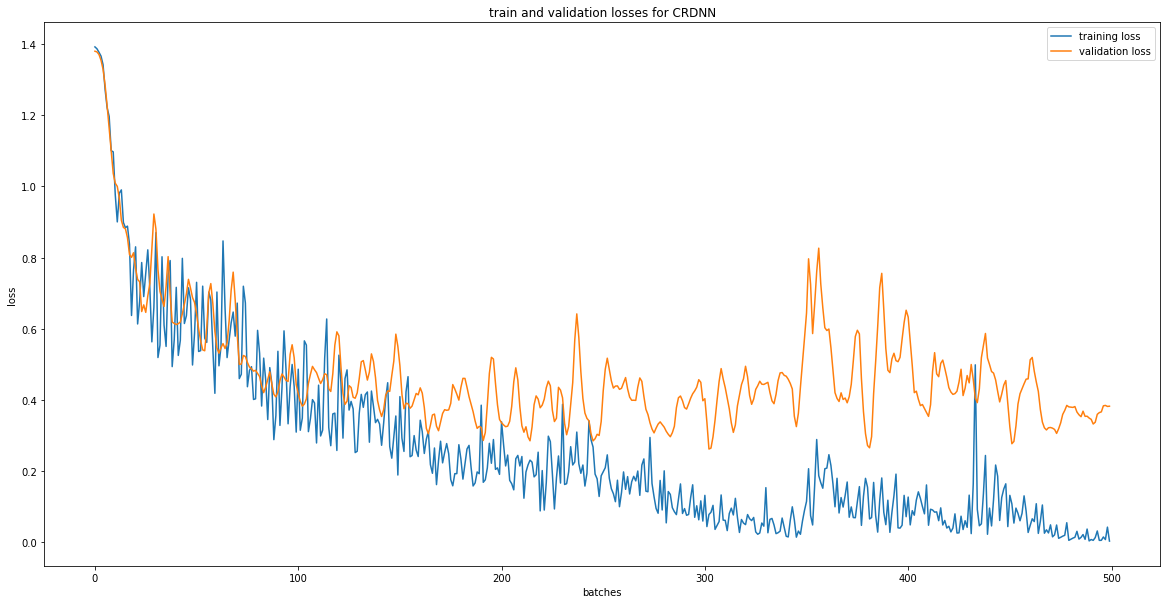

In [ ]:
plot_numerical_arrays([training_loss_array, validation_loss_array], ['training loss', 'validation loss'], 
                      xlabel='batches', ylabel='loss', title='train and validation losses for ' + 'CRDNN')

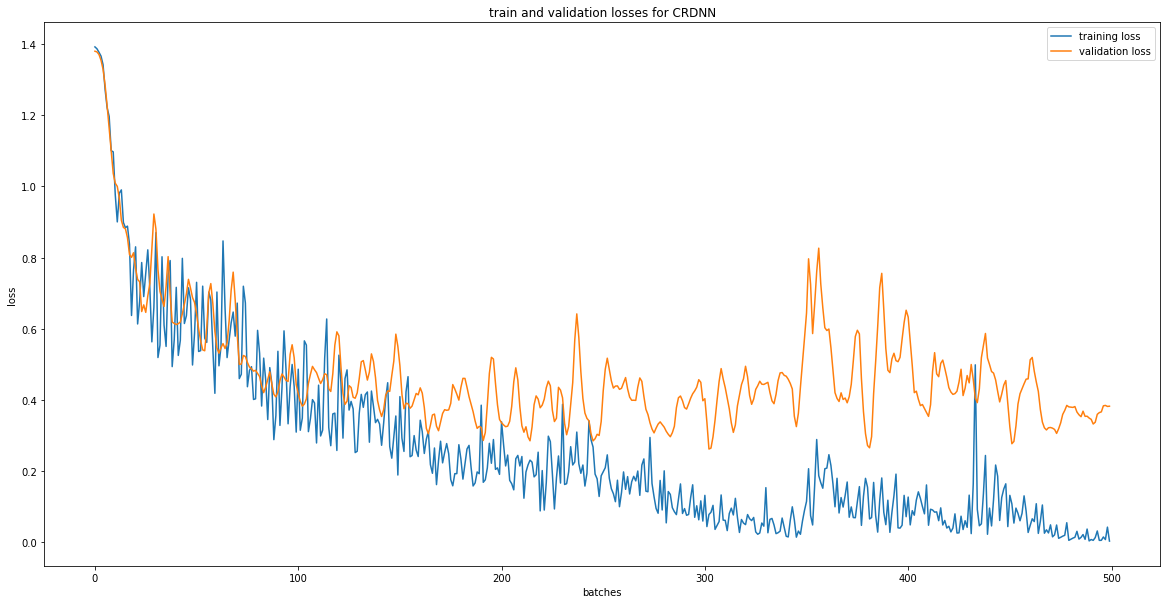

In [ ]:
plot_numerical_arrays([training_loss_array, validation_loss_array], ['training loss', 'validation loss'], 
                      xlabel='batches', ylabel='loss', title='train and validation losses for ' + 'CRDNN')

## Testing

In [ ]:
model.load_state_dict(torch.load('saved_CRNN_wave.pt'))

<All keys matched successfully>

In [ ]:
X_val_2d = X_val.reshape((-1, 1, n_time, n_feat))
X_test_2d = X_test.reshape((-1, 1, n_time, n_feat))

In [ ]:
print('validation accuracy: %.2f%%' % (cal_accuracy(model, X_val_2d, y_val) * 100))

validation accuracy: 93.33%


In [ ]:
print('testing accuracy: %.2f%%' % (cal_accuracy(model, X_test_2d, y_test) * 100))

testing accuracy: 87.50%
